In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        mean = x.mean(dim=[2, 3], keepdim=True)
        variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

    

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x



In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type= 'none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4
norm_type = 'none'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
------------------------Training Started------------------------


100%|██████████| 263/263 [00:17<00:00, 15.28it/s]


Epoch:  0 Train Loss:  0.09241338016410029 Train Accuracy:  9.786857939286806 Train F1 Macro:  0.0859096847689125 Train F1 Micro:  0.09786857939286807
Epoch:  0 Validation Loss:  0.08651096666665475 Validation Accuracy:  14.98870795197908 Validation F1 Macro:  0.09986684664951635 Validation F1 Micro:  0.1498870795197908
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.76it/s]


Epoch:  1 Train Loss:  0.08515179173871898 Train Accuracy:  15.19189584254003 Train F1 Macro:  0.1358310340208664 Train F1 Micro:  0.1519189584254003
Epoch:  1 Validation Loss:  0.08066266747500403 Validation Accuracy:  18.483299655295376 Validation F1 Macro:  0.15932023565711967 Validation F1 Micro:  0.18483299655295377
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.60it/s]


Epoch:  2 Train Loss:  0.08034589227644685 Train Accuracy:  18.754461705816365 Train F1 Macro:  0.17015885025741181 Train F1 Micro:  0.18754461705816364
Epoch:  2 Validation Loss:  0.07822842650672535 Validation Accuracy:  20.503981932723168 Validation F1 Macro:  0.1733542147116056 Validation F1 Micro:  0.20503981932723167
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.66it/s]


Epoch:  3 Train Loss:  0.07850649992500645 Train Accuracy:  20.372573681884624 Train F1 Macro:  0.18647616768439068 Train F1 Micro:  0.20372573681884623
Epoch:  3 Validation Loss:  0.07717601494600383 Validation Accuracy:  21.633186734815165 Validation F1 Macro:  0.19084155405900818 Validation F1 Micro:  0.21633186734815166
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.68it/s]


Epoch:  4 Train Loss:  0.07665786163428502 Train Accuracy:  22.687561614032703 Train F1 Macro:  0.2117403100405633 Train F1 Micro:  0.22687561614032703
Epoch:  4 Validation Loss:  0.07520202279416784 Validation Accuracy:  23.87970997266136 Validation F1 Macro:  0.21423269132724443 Validation F1 Micro:  0.2387970997266136
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.61it/s]


Epoch:  5 Train Loss:  0.07505773621047666 Train Accuracy:  24.513036679471053 Train F1 Macro:  0.2319212176672002 Train F1 Micro:  0.24513036679471054
Epoch:  5 Validation Loss:  0.07283028726782935 Validation Accuracy:  26.482824200641865 Validation F1 Macro:  0.25302287308988525 Validation F1 Micro:  0.26482824200641863
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.78it/s]


Epoch:  6 Train Loss:  0.07340169012106855 Train Accuracy:  25.83880069347656 Train F1 Macro:  0.24766325144246362 Train F1 Micro:  0.2583880069347656
Epoch:  6 Validation Loss:  0.07296987912125782 Validation Accuracy:  25.69832402234637 Validation F1 Macro:  0.2378716051768017 Validation F1 Micro:  0.2569832402234637
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.59it/s]


Epoch:  7 Train Loss:  0.07202535413620234 Train Accuracy:  27.426318115375466 Train F1 Macro:  0.2645747550008651 Train F1 Micro:  0.27426318115375464
Epoch:  7 Validation Loss:  0.07009914604900255 Validation Accuracy:  29.35932485439201 Validation F1 Macro:  0.2780052487733125 Validation F1 Micro:  0.2935932485439201
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.43it/s]


Epoch:  8 Train Loss:  0.0708909665281591 Train Accuracy:  28.731685759934734 Train F1 Macro:  0.27782331949981187 Train F1 Micro:  0.28731685759934733
Epoch:  8 Validation Loss:  0.06941820615029116 Validation Accuracy:  30.108165933674076 Validation F1 Macro:  0.28200458744528833 Validation F1 Micro:  0.30108165933674075
---------------------------------------------------------------


100%|██████████| 263/263 [00:13<00:00, 18.79it/s]


Epoch:  9 Train Loss:  0.0695852530490097 Train Accuracy:  29.94187034707822 Train F1 Macro:  0.2896702606229895 Train F1 Micro:  0.2994187034707822
Epoch:  9 Validation Loss:  0.06815027521805178 Validation Accuracy:  32.069416379412814 Validation F1 Macro:  0.3003869147690781 Validation F1 Micro:  0.32069416379412813
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.48it/s]


Epoch:  10 Train Loss:  0.06868195291419249 Train Accuracy:  30.88690213142061 Train F1 Macro:  0.29991270671702114 Train F1 Micro:  0.30886902131420607
Epoch:  10 Validation Loss:  0.06793419131339411 Validation Accuracy:  31.72471175561631 Validation F1 Macro:  0.29470852749722753 Validation F1 Micro:  0.3172471175561631
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.73it/s]


Epoch:  11 Train Loss:  0.06774875660758294 Train Accuracy:  32.2568582792263 Train F1 Macro:  0.31331644076142046 Train F1 Micro:  0.32256858279226297
Epoch:  11 Validation Loss:  0.06496221051691659 Validation Accuracy:  34.779507904433615 Validation F1 Macro:  0.33640423528695784 Validation F1 Micro:  0.34779507904433615
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.71it/s]


Epoch:  12 Train Loss:  0.06669758774144371 Train Accuracy:  32.889145732059696 Train F1 Macro:  0.3204405570946164 Train F1 Micro:  0.32889145732059694
Epoch:  12 Validation Loss:  0.06718328395015091 Validation Accuracy:  32.8420301913705 Validation F1 Macro:  0.31275311058907507 Validation F1 Micro:  0.32842030191370497
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.53it/s]


Epoch:  13 Train Loss:  0.065828466790657 Train Accuracy:  34.14012305809566 Train F1 Macro:  0.3331860191867652 Train F1 Micro:  0.3414012305809566
Epoch:  13 Validation Loss:  0.06530560035704433 Validation Accuracy:  35.29062165695947 Validation F1 Macro:  0.3436574289973899 Validation F1 Micro:  0.3529062165695947
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.66it/s]


Epoch:  14 Train Loss:  0.06500551599039034 Train Accuracy:  34.99337117992997 Train F1 Macro:  0.342075453160922 Train F1 Micro:  0.3499337117992997
Epoch:  14 Validation Loss:  0.0648406027302254 Validation Accuracy:  34.94591703316296 Validation F1 Macro:  0.3424465062374313 Validation F1 Micro:  0.3494591703316296
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.57it/s]


Epoch:  15 Train Loss:  0.06408227137593396 Train Accuracy:  35.79562837814869 Train F1 Macro:  0.35049607689825374 Train F1 Micro:  0.357956283781487
Epoch:  15 Validation Loss:  0.06287834159148713 Validation Accuracy:  37.89373588493997 Validation F1 Macro:  0.36424552447682396 Validation F1 Micro:  0.3789373588493997
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.58it/s]


Epoch:  16 Train Loss:  0.06311449169541222 Train Accuracy:  36.60468436618282 Train F1 Macro:  0.35970031700017296 Train F1 Micro:  0.3660468436618282
Epoch:  16 Validation Loss:  0.06214330035696752 Validation Accuracy:  37.72732675621063 Validation F1 Macro:  0.3665731195347764 Validation F1 Micro:  0.3772732675621063
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.67it/s]


Epoch:  17 Train Loss:  0.06229888446213424 Train Accuracy:  37.55311554543292 Train F1 Macro:  0.369298989880491 Train F1 Micro:  0.37553115545432914
Epoch:  17 Validation Loss:  0.06144640577628697 Validation Accuracy:  39.12991798407227 Validation F1 Macro:  0.37663068564689206 Validation F1 Micro:  0.39129917984072266
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.58it/s]


Epoch:  18 Train Loss:  0.0617333425275854 Train Accuracy:  38.10721691538906 Train F1 Macro:  0.37484273205071533 Train F1 Micro:  0.3810721691538906
Epoch:  18 Validation Loss:  0.06042238365352671 Validation Accuracy:  40.152145489123974 Validation F1 Macro:  0.3920365077029523 Validation F1 Micro:  0.40152145489123975
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.65it/s]


Epoch:  19 Train Loss:  0.06109010164607295 Train Accuracy:  38.79049529183805 Train F1 Macro:  0.3824947067836284 Train F1 Micro:  0.38790495291838045
Epoch:  19 Validation Loss:  0.05996383786640736 Validation Accuracy:  39.41519077617972 Validation F1 Macro:  0.38631340020134713 Validation F1 Micro:  0.39415190776179726
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.60it/s]


Epoch:  20 Train Loss:  0.06039332906252491 Train Accuracy:  39.310602712717134 Train F1 Macro:  0.387560544866595 Train F1 Micro:  0.39310602712717135
Epoch:  20 Validation Loss:  0.059839781081932955 Validation Accuracy:  39.6172590039225 Validation F1 Macro:  0.3837878010667658 Validation F1 Micro:  0.396172590039225
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.43it/s]


Epoch:  21 Train Loss:  0.059940217377461365 Train Accuracy:  39.83750892341163 Train F1 Macro:  0.3933032685469597 Train F1 Micro:  0.39837508923411635
Epoch:  21 Validation Loss:  0.058636567828687265 Validation Accuracy:  41.82812314275526 Validation F1 Macro:  0.4078854495729133 Validation F1 Micro:  0.4182812314275526
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.73it/s]


Epoch:  22 Train Loss:  0.05927180617396292 Train Accuracy:  40.435802427167964 Train F1 Macro:  0.39948168836079717 Train F1 Micro:  0.4043580242716796
Epoch:  22 Validation Loss:  0.05769040416512126 Validation Accuracy:  42.60073695471294 Validation F1 Macro:  0.41950964449638917 Validation F1 Micro:  0.4260073695471294
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.50it/s]


Epoch:  23 Train Loss:  0.05873915716100526 Train Accuracy:  41.10888261889384 Train F1 Macro:  0.406805769341492 Train F1 Micro:  0.4110888261889384
Epoch:  23 Validation Loss:  0.05853871589719817 Validation Accuracy:  41.18625936051349 Validation F1 Macro:  0.4016860622020929 Validation F1 Micro:  0.4118625936051349
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.23it/s]


Epoch:  24 Train Loss:  0.05813566844208939 Train Accuracy:  41.7751640208043 Train F1 Macro:  0.41365598827396477 Train F1 Micro:  0.41775164020804295
Epoch:  24 Validation Loss:  0.058171157808291366 Validation Accuracy:  42.327350528943306 Validation F1 Macro:  0.4112025919600245 Validation F1 Micro:  0.423273505289433
---------------------------------------------------------------


100%|██████████| 263/263 [00:13<00:00, 18.79it/s]


Epoch:  25 Train Loss:  0.05775587749289928 Train Accuracy:  41.979127715266685 Train F1 Macro:  0.41591709026520435 Train F1 Micro:  0.41979127715266684
Epoch:  25 Validation Loss:  0.05729525890628634 Validation Accuracy:  43.04053250921193 Validation F1 Macro:  0.4138093754972754 Validation F1 Micro:  0.4304053250921193
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.35it/s]


Epoch:  26 Train Loss:  0.05706433585771516 Train Accuracy:  42.8867661556243 Train F1 Macro:  0.4253967782816567 Train F1 Micro:  0.42886766155624295
Epoch:  26 Validation Loss:  0.0567220116602486 Validation Accuracy:  43.0048734101985 Validation F1 Macro:  0.4259097939733189 Validation F1 Micro:  0.430048734101985
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.62it/s]


Epoch:  27 Train Loss:  0.05664895432816488 Train Accuracy:  43.44426692048815 Train F1 Macro:  0.4309850581669073 Train F1 Micro:  0.4344426692048815
Epoch:  27 Validation Loss:  0.05583918977050142 Validation Accuracy:  43.967669083561155 Validation F1 Macro:  0.4365547897253541 Validation F1 Micro:  0.43967669083561156
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.38it/s]


Epoch:  28 Train Loss:  0.05626082111556659 Train Accuracy:  43.491858449196044 Train F1 Macro:  0.43179060425239074 Train F1 Micro:  0.4349185844919604
Epoch:  28 Validation Loss:  0.056305143636343924 Validation Accuracy:  44.95423748959943 Validation F1 Macro:  0.44419433272364045 Validation F1 Micro:  0.4495423748959943
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.13it/s]


Epoch:  29 Train Loss:  0.055968674504019794 Train Accuracy:  44.01536526498283 Train F1 Macro:  0.43739339697479446 Train F1 Micro:  0.4401536526498283
Epoch:  29 Validation Loss:  0.05495754127679279 Validation Accuracy:  44.97801022227505 Validation F1 Macro:  0.4427742832243776 Validation F1 Micro:  0.4497801022227505
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.64it/s]


Epoch:  30 Train Loss:  0.055606885879819525 Train Accuracy:  44.60346058401605 Train F1 Macro:  0.44301184120565346 Train F1 Micro:  0.44603460584016047
Epoch:  30 Validation Loss:  0.05429531906796851 Validation Accuracy:  46.15476048971829 Validation F1 Macro:  0.45431342984038536 Validation F1 Micro:  0.461547604897183
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.43it/s]


Epoch:  31 Train Loss:  0.055085081394732546 Train Accuracy:  44.86181459700173 Train F1 Macro:  0.4459412568432294 Train F1 Micro:  0.44861814597001737
Epoch:  31 Validation Loss:  0.054433788323563936 Validation Accuracy:  46.39248781647451 Validation F1 Macro:  0.46141680767568616 Validation F1 Micro:  0.46392487816474504
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.72it/s]


Epoch:  32 Train Loss:  0.05469888555901045 Train Accuracy:  45.43631233640412 Train F1 Macro:  0.45146479537949974 Train F1 Micro:  0.4543631233640412
Epoch:  32 Validation Loss:  0.05395556937623758 Validation Accuracy:  46.214192321407346 Validation F1 Macro:  0.45900548608728114 Validation F1 Micro:  0.46214192321407344
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.63it/s]


Epoch:  33 Train Loss:  0.05441183768240402 Train Accuracy:  45.942822177652374 Train F1 Macro:  0.4572103206376283 Train F1 Micro:  0.45942822177652376
Epoch:  33 Validation Loss:  0.0542302561843493 Validation Accuracy:  45.54855580648996 Validation F1 Macro:  0.4491680266260974 Validation F1 Micro:  0.4554855580648995
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.37it/s]


Epoch:  34 Train Loss:  0.05412367650360871 Train Accuracy:  46.109392528129995 Train F1 Macro:  0.45851509347625646 Train F1 Micro:  0.46109392528129994
Epoch:  34 Validation Loss:  0.05349319560071822 Validation Accuracy:  46.677760608581956 Validation F1 Macro:  0.46266819463058995 Validation F1 Micro:  0.46677760608581953
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.41it/s]


Epoch:  35 Train Loss:  0.05376077092601209 Train Accuracy:  46.39834109528504 Train F1 Macro:  0.46170499256648484 Train F1 Micro:  0.4639834109528504
Epoch:  35 Validation Loss:  0.05395095426007852 Validation Accuracy:  46.14287412338049 Validation F1 Macro:  0.45584618755180073 Validation F1 Micro:  0.46142874123380484
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.20it/s]


Epoch:  36 Train Loss:  0.053463646417877084 Train Accuracy:  46.73488119114798 Train F1 Macro:  0.4652039062989606 Train F1 Micro:  0.46734881191147976
Epoch:  36 Validation Loss:  0.05306682083080459 Validation Accuracy:  47.438488054201834 Validation F1 Macro:  0.4684608745522831 Validation F1 Micro:  0.47438488054201833
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.22it/s]


Epoch:  37 Train Loss:  0.05323257044129431 Train Accuracy:  47.163204949518985 Train F1 Macro:  0.4692529318232686 Train F1 Micro:  0.47163204949518983
Epoch:  37 Validation Loss:  0.05313597051153338 Validation Accuracy:  47.949601806727685 Validation F1 Macro:  0.47171176865027115 Validation F1 Micro:  0.4794960180672768
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.42it/s]


Epoch:  38 Train Loss:  0.05296521127339462 Train Accuracy:  47.418159567596966 Train F1 Macro:  0.4721192458835205 Train F1 Micro:  0.4741815956759697
Epoch:  38 Validation Loss:  0.05287221643724354 Validation Accuracy:  47.67621538095804 Validation F1 Macro:  0.4721586127393833 Validation F1 Micro:  0.4767621538095804
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 17.93it/s]


Epoch:  39 Train Loss:  0.05271634342482653 Train Accuracy:  47.61532447224394 Train F1 Macro:  0.473994615476712 Train F1 Micro:  0.4761532447224394
Epoch:  39 Validation Loss:  0.05223204566567204 Validation Accuracy:  48.67467015333413 Validation F1 Macro:  0.4837584339695449 Validation F1 Micro:  0.48674670153334126
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.48it/s]


Epoch:  40 Train Loss:  0.05248459873020509 Train Accuracy:  47.9110718292144 Train F1 Macro:  0.4772866791000761 Train F1 Micro:  0.479110718292144
Epoch:  40 Validation Loss:  0.05226140360294901 Validation Accuracy:  48.8648520147391 Validation F1 Macro:  0.4865174818968804 Validation F1 Micro:  0.48864852014739096
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.37it/s]


Epoch:  41 Train Loss:  0.052340272446153975 Train Accuracy:  48.13203249821532 Train F1 Macro:  0.47935004158513295 Train F1 Micro:  0.48132032498215316
Epoch:  41 Validation Loss:  0.05187089795960295 Validation Accuracy:  49.601806727683346 Validation F1 Macro:  0.49198386214210593 Validation F1 Micro:  0.49601806727683345
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.28it/s]


Epoch:  42 Train Loss:  0.052129431333670574 Train Accuracy:  48.16262705238468 Train F1 Macro:  0.47952584492192996 Train F1 Micro:  0.48162627052384677
Epoch:  42 Validation Loss:  0.051985768650227915 Validation Accuracy:  48.72221561868537 Validation F1 Macro:  0.4865826440625093 Validation F1 Micro:  0.48722215618685366
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.47it/s]


Epoch:  43 Train Loss:  0.05192011280914383 Train Accuracy:  48.70992963252541 Train F1 Macro:  0.4854481317093231 Train F1 Micro:  0.4870992963252541
Epoch:  43 Validation Loss:  0.05178507208526595 Validation Accuracy:  49.375965767264944 Validation F1 Macro:  0.49109791609983033 Validation F1 Micro:  0.49375965767264945
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.05it/s]


Epoch:  44 Train Loss:  0.05175983380196667 Train Accuracy:  48.7575211612333 Train F1 Macro:  0.48571196048590337 Train F1 Micro:  0.487575211612333
Epoch:  44 Validation Loss:  0.051322875359559136 Validation Accuracy:  49.50671579698086 Validation F1 Macro:  0.49261545834913506 Validation F1 Micro:  0.4950671579698086
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.38it/s]


Epoch:  45 Train Loss:  0.05166096739511736 Train Accuracy:  48.96148485569569 Train F1 Macro:  0.48759788875711074 Train F1 Micro:  0.48961484855695686
Epoch:  45 Validation Loss:  0.05126616065090964 Validation Accuracy:  49.56614762866992 Validation F1 Macro:  0.4937227553681551 Validation F1 Micro:  0.49566147628669915
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.72it/s]


Epoch:  46 Train Loss:  0.051528422505947066 Train Accuracy:  49.226637658496784 Train F1 Macro:  0.490466713159347 Train F1 Micro:  0.49226637658496786
Epoch:  46 Validation Loss:  0.0512745823096991 Validation Accuracy:  50.23178414358731 Validation F1 Macro:  0.4990837974088344 Validation F1 Micro:  0.5023178414358731
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.60it/s]


Epoch:  47 Train Loss:  0.05137462884762125 Train Accuracy:  49.35581466498963 Train F1 Macro:  0.4917112770924824 Train F1 Micro:  0.49355814664989633
Epoch:  47 Validation Loss:  0.050927919988242254 Validation Accuracy:  49.803874955426124 Validation F1 Macro:  0.49688397493885594 Validation F1 Micro:  0.49803874955426125
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.63it/s]


Epoch:  48 Train Loss:  0.05125815906389146 Train Accuracy:  49.11105823163477 Train F1 Macro:  0.4895007396345667 Train F1 Micro:  0.4911105823163477
Epoch:  48 Validation Loss:  0.05117440837594058 Validation Accuracy:  49.50671579698086 Validation F1 Macro:  0.4923212275471501 Validation F1 Micro:  0.4950671579698086
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 18.64it/s]


Epoch:  49 Train Loss:  0.05117948725452339 Train Accuracy:  49.325220110820275 Train F1 Macro:  0.4916054415229156 Train F1 Micro:  0.4932522011082027
Epoch:  49 Validation Loss:  0.051052744296760974 Validation Accuracy:  49.732556757399266 Validation F1 Macro:  0.4946003983282091 Validation F1 Micro:  0.49732556757399266
---------------------------------------------------------------


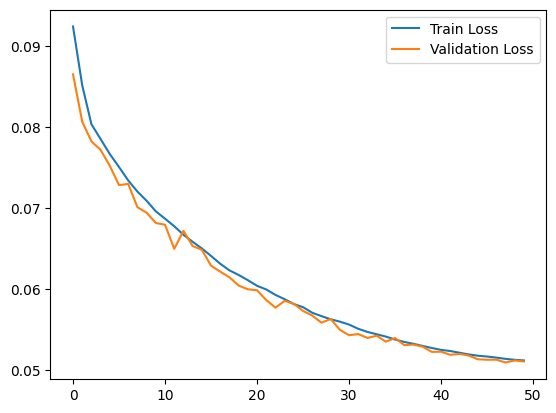

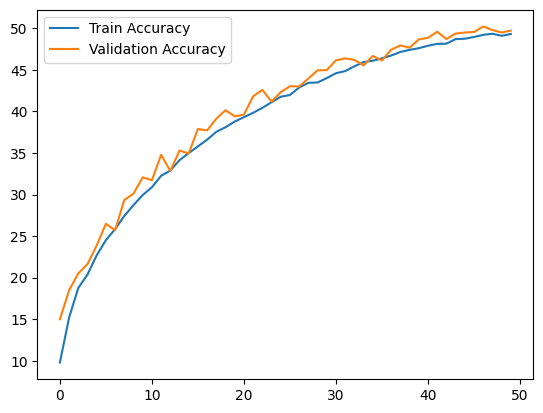

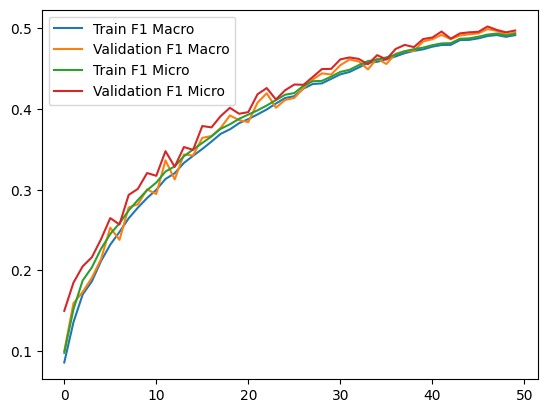

In [5]:
def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n, norm_type)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part2-nonorm', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part2-nonorm.pth')
    
    
training()

    
        